# Malaria cell image



**1. In this exercise, we will build a CNN model to classify malaria infection from image data sets. The followings are examples of uninfected (left) and infected (right) cells. You should solve the problem based on `cell image.zip` file(`HW5.ipynb` is included in this file) that I uploaded at LearnUs.**

**(a) Search for the definition of the following function:**
- `tf.keras.preprocession.image.ImageGenerator`

**Explain (1) the role and (2) arguments (options) of this function. Since there are too many arguments for this function, you may explain only 5 of them. You can take a look at descriptions from https://keras.io/guides/. But do not simply copy-paste the descriptions. You should paraphrase the descriptions. (25 points)**

(1) Role: 이미지 파일을 모델 피팅이 가능한 tensor 형식으로 변환해준다.

(2) Arguments
- `width_shift_range`: input 이미지가 수평 방향으로 이동된다.
- `brightness_range`: input 이미지의 밝기가 조정된다.
- `horizontal_flip`: input 이미지가 수평 방향으로 반전된다.
- `rescale`: input값들의 범위를 재설정해준다. Malaria cell image classification 데이터의 경우 RGB 채널값인 [0, 255] 범위에 있기 때문에 `rescale=1/255.0`을 통해 [0, 1] 범위로 표준화했다.
- `validation_split`: input data 중 입력된 비율만큼을 validation data로 나누어준다. Malaria cell image classification에서는 `validation_split=0.2`를 통해 8:2로 train data와 test data를 split했다.

**예시**

(width shift)
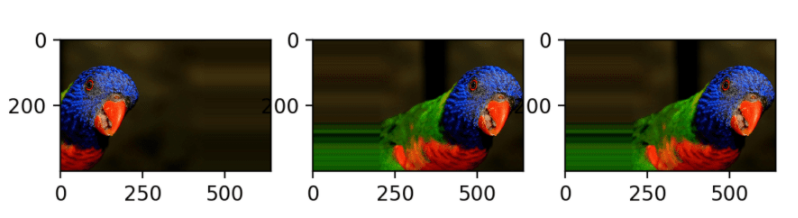

(brightness augmentation)
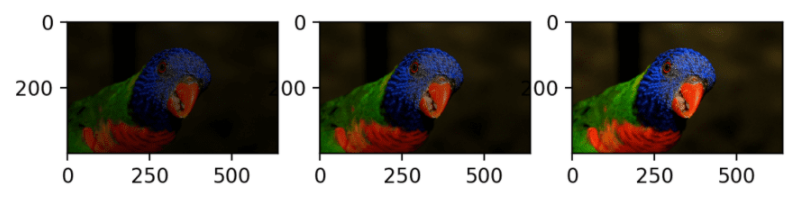

(horizontal flip)
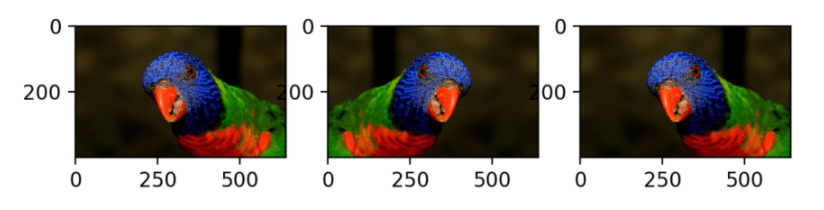

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

### Displaying Uninfected and Infected Cell tissues


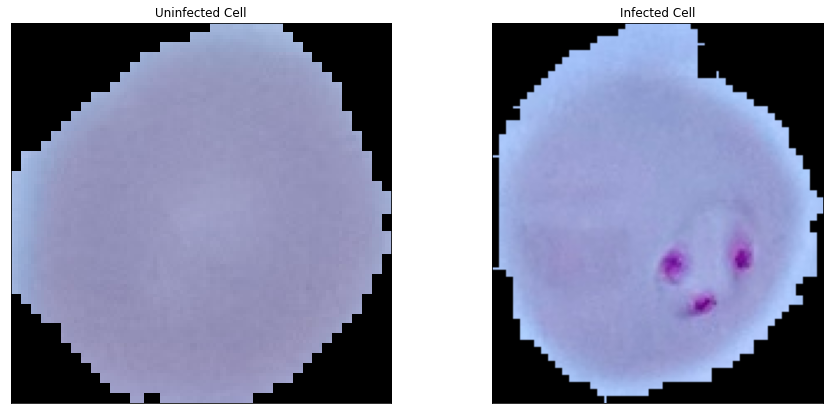

In [2]:
upic='../cell_images/Uninfected/C1_thinF_IMG_20150604_104722_cell_9.png'
apic='../cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png'
plt.figure(1, figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(upic))
plt.title('Uninfected Cell')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(apic))
plt.title('Infected Cell')
plt.xticks([]), plt.yticks([])

plt.show()

### Dividing Dataset into two folders train and test


In [3]:
width = 128
height = 128
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [4]:
trainDatagen = datagen.flow_from_directory(directory='../cell_images/',
                                           target_size=(width,height),
                                           class_mode='binary',
                                           batch_size=16,
                                           subset='training')

Found 22048 images belonging to 2 classes.


In [5]:
valDatagen = datagen.flow_from_directory(directory='../cell_images/',
                                         target_size=(width,height),
                                         class_mode='binary',
                                         batch_size=16,
                                         subset='validation')

Found 5510 images belonging to 2 classes.


**(b) Explain [3], [4], [5] part of the code (in HW5.ipynb). What are these steps for? (15 points)**

cell images에 있는 이미지 파일들을 tensor 파일로 변환해주는 단계다. <br>
[3]에서는 input data의 가로 세로 길이를 지정해준 뒤 (a)-(2)에서 설명한 것처럼 rescale과 validation split 조건을 hyperparameter로 설정해 주었고, <br>
[4]와 [5]에서는 디렉토리에 있는 사진들을 [3]에서 정한 가로 세로 길이, scale, train-validation split 비율에 맞게 train/validation input tensor data로 변환해 주었다. <br>
이미지들은 binary class로 label이 붙었고, 16개씩 batch로 묶여있다.

**(c) Feel free to build your own CNN. You can add convolutional layers, max-pooling
layers, and dropout layers. You may choose any options to build your own model.
Note that you have to use the sigmoid activation function at the last layer for
binary classification. Using model.summary function, report the structure of your
CNN. (25 points)**

In [6]:
for image_batch, labels_batch in trainDatagen:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 128, 128, 3)
(16,)


Input image batch shape는 (16, 128, 128, 3)이다. <br>
3~5에서 정의해준 대로 128 $\times$ 128 $\times$ 3 이미지들이 16개씩 batch로 묶여있는 형태다.

In [7]:
# define the keras model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid') # for binary classification
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 16)      1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        51264     
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8

Input → Convolutional → Convolutional → Maxpooling → Convolutional → Dropout → Fully connected 구조로 이루어진 모델을 만들었다. 총 82945개의 parameter가 필요한 모델이다.<br>
Binary classification이기 때문에 fully connected layer로 데이터를 flatten시켜줘야 하고, sigmoid activation을 사용해야 한다.

**(d) Compile your model. You can use the binary cross-entropy loss function. Report the classification accuracy for both training and test data sets. If your model accuracy is low (< 0.8), try different CNN structures. (35 points)**

In [9]:
# model compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# model fit
model.fit(trainDatagen, validation_data=valDatagen, epochs=30)

Epoch 1/30
1378/1378 [==============================] - 740s 536ms/step - loss: 0.6763 - accuracy: 0.5760 - val_loss: 0.6602 - val_accuracy: 0.6192
Epoch 2/30
1378/1378 [==============================] - 738s 535ms/step - loss: 0.6214 - accuracy: 0.6655 - val_loss: 0.6471 - val_accuracy: 0.6347
Epoch 3/30
1378/1378 [==============================] - 734s 533ms/step - loss: 0.5881 - accuracy: 0.6974 - val_loss: 0.6355 - val_accuracy: 0.6492
Epoch 4/30
1378/1378 [==============================] - 733s 532ms/step - loss: 0.5571 - accuracy: 0.7159 - val_loss: 0.6381 - val_accuracy: 0.6430
Epoch 5/30
1378/1378 [==============================] - 734s 532ms/step - loss: 0.5229 - accuracy: 0.7407 - val_loss: 0.6465 - val_accuracy: 0.6505
Epoch 6/30
1378/1378 [==============================] - 738s 535ms/step - loss: 0.2743 - accuracy: 0.8912 - val_loss: 0.2997 - val_accuracy: 0.8898
Epoch 7/30
1378/1378 [==============================] - 739s 536ms/step - loss: 0.1283 - accuracy: 0.9578 - val_

Epoch = 30으로 모델을 피팅했을 때 binary cross entropy loss function을 이용한 train loss는 0.02, **train accuracy는 0.9943**, validation(test) loss는 0.6030, **validation(test) accuracy는 0.9165**로 계산된다. <br>
살짝 overfitting돼 보이는데, epoch를 10대로 좀 더 낮게 잡는 게 좋았을 법하다. 그래도 전체적인 accuracy가 괜찮으니 다시 피팅하진 않겠다.